# **Patch Camelyon Project**

GitHub Repo - https://github.com/SubhikshaSaravanan/PCam-CNNs-Attention-Analysis

Blog Post - https://pcam-dataset-cnn-and-attention-analysis.hashnode.dev/analyzing-the-pcam-dataset-with-cnns-and-attention-mechanisms

### **Import required resources**

In [ ]:
#import all the required packages.
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import warnings
import seaborn as sns
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity
from google.colab import drive
import tensorflow_datasets as tfds
import numpy as np
import warnings
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.models import load_model
from collections import Counter

warnings.filterwarnings("ignore")

For this project, we utilized Google Compute Engine (TPU), which offers greater computational power than a GPU and is highly optimized for handling tensors, making it ideal for our tensor-based dataset.

In [ ]:
try: #Resource Allocation
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"Running on TPU: {tpu.cluster_spec().as_dict()}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on GPU: {gpus[0].name}")
    else:
        cpus = tf.config.list_physical_devices('CPU')
        print(f"Running on CPU: {cpus[0].name}")

Running on TPU: {}


### **Dataset Loading/Splitting**

We selected the PatchCamelyon dataset and imported it from TensorFlow Datasets. The dataset was split with 85% allocated for training, 15% for validation, and a test dataset is separate.

In [ ]:
train_dataset, val_dataset, test_dataset = tfds.load(
    'patch_camelyon',
    split=['train[:85%]', 'train[85%:]', 'test'],
    as_supervised=True
) #please note that the splits are sourced from the dataset itself. Hence, no additional splitting per se is required. Split Data is already available.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.ODWY7D_2.0.0/patch_camelyon-test.tfrecord*...:  …

Generating train examples...:   0%|          | 0/262144 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.ODWY7D_2.0.0/patch_camelyon-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.ODWY7D_2.0.0/patch_camelyon-validation.tfrecord*…

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


### Data Augmentation

For the CNN model, data augmentation was not implemented since no overfitting was observed during training. However, for the CNN model with an attention mechanism, data augmentation was applied, including random flipping and adjustments to brightness and contrast.

In [ ]:
def preprocess(image, label, augment=False):
    image = tf.image.convert_image_dtype(image, tf.float32)

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

During dataset preprocessing, we shuffled the data and divided it into batches of size 128.
Note: Data augmentation was applied only to the training images.

In [ ]:
train_dataset = (train_dataset
                 .map(lambda x, y: preprocess(x, y, augment=True))
                 .shuffle(1000)
                 .batch(128)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
val_dataset = (val_dataset
               .map(preprocess)
               .batch(128)
               .cache()
               .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
test_dataset = (test_dataset
                .map(preprocess)
                .batch(128)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))

### **Exploratory Data Analysis (EDA)**

#### a) Random Patches in Train and Test Data per class (Data Visualization)

Train Dataset Images:


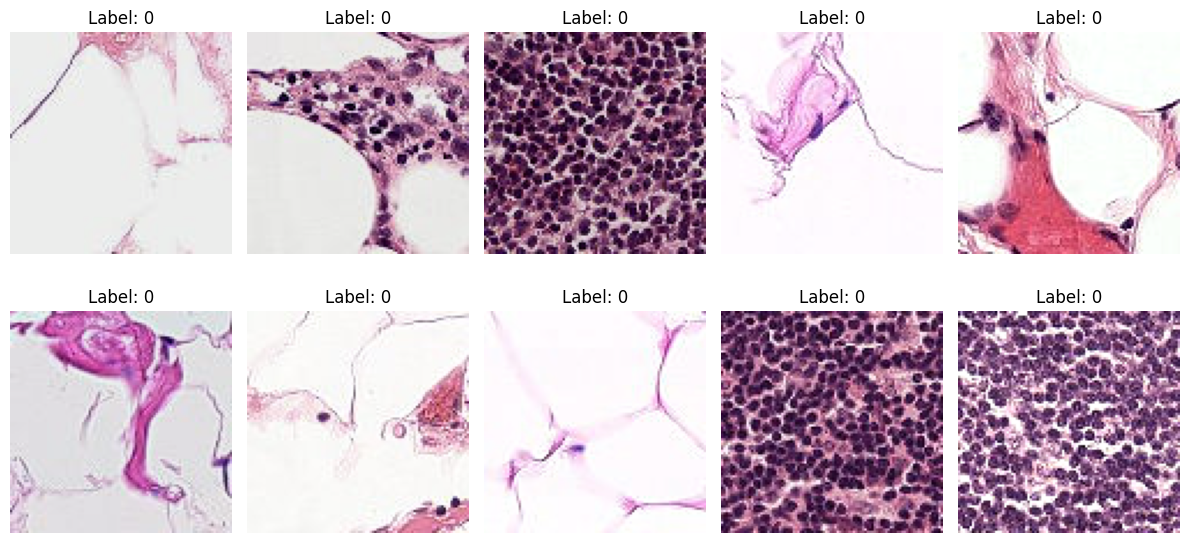

Test Dataset Images:


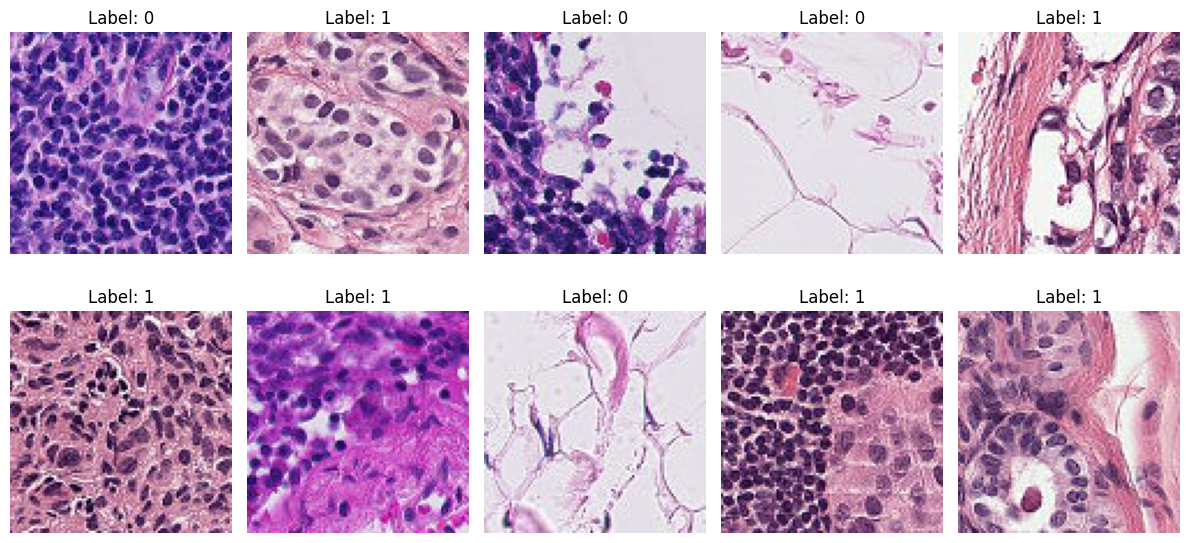

In [ ]:
def plot_images(dataset, num_images=10): #plot random patches from the Test and Train dataset to visualize the images in the dataset.
    plt.figure(figsize=(12, 6))
    images_plotted = 0

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if images_plotted < num_images:
                plt.subplot(2, 5, images_plotted + 1)
                plt.imshow(images[i].numpy())
                plt.title(f"Label: {labels[i].numpy():.0f}")
                plt.axis('off')
                images_plotted += 1
            else:
                break
        if images_plotted >= num_images:
            break

    plt.tight_layout()
    plt.show()

print("Train Dataset Images:")
plot_images(train_dataset)

print("Test Dataset Images:")
plot_images(test_dataset)

**Note - Label 0 represents No Tumor. Label 1 represents Tumor presence.**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#### b) Class Distribution

In [ ]:
label_counts = Counter()

for _, labels in train_dataset:
    label_counts.update(labels.numpy())

print("Train Class distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")


Train Class distribution:
Label 0: 111494 images
Label 1: 111328 images


In [ ]:
label_counts = Counter()

for _, labels in val_dataset:
    label_counts.update(labels.numpy())

print("Valid Class distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Valid Class distribution:
Label 1: 19744 images
Label 0: 19578 images


In [ ]:
label_counts = Counter()

for _, labels in test_dataset:
    label_counts.update(labels.numpy())

print("Test Class distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Test Class distribution:
Label 0: 16391 images
Label 1: 16377 images


#### c) Translation from RGB to HED space
##### *Motivation - These images are stained with Haemotoxylin, Eosin and Diaminobenzidine which make it purplish, pinkish/redish or brownish in color. We want to see how every image overlays to be the image it is with separate layers of the subsequent dyes.*


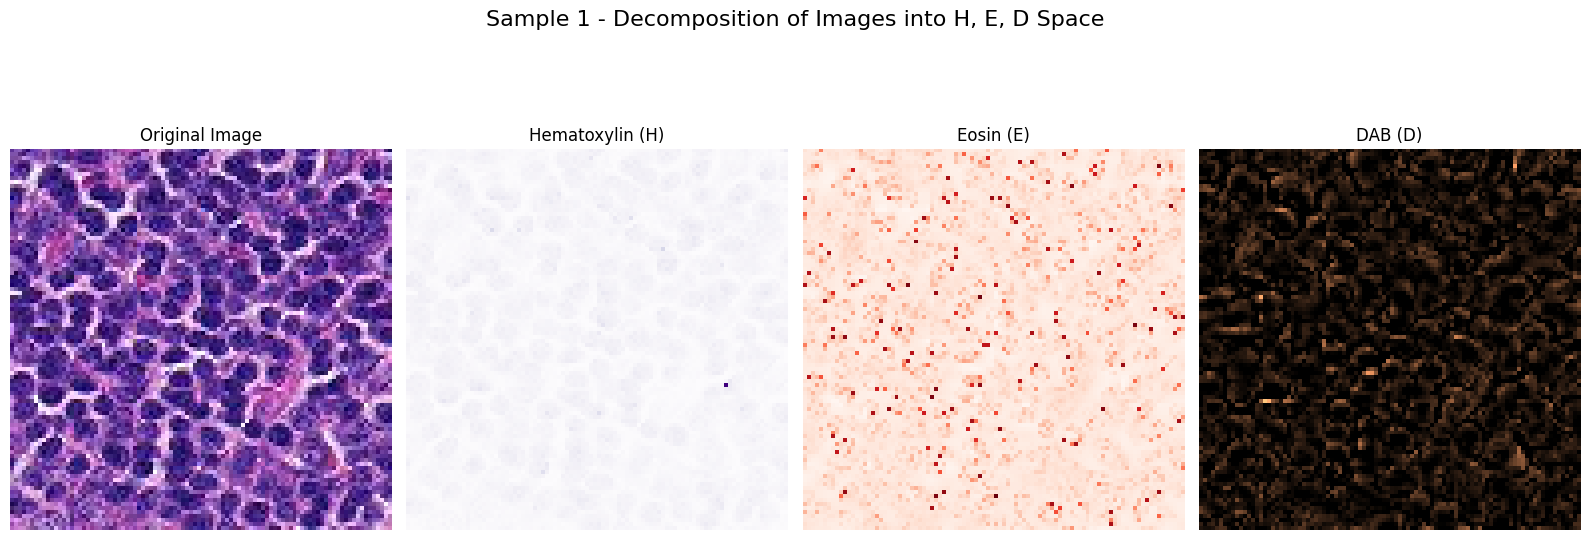

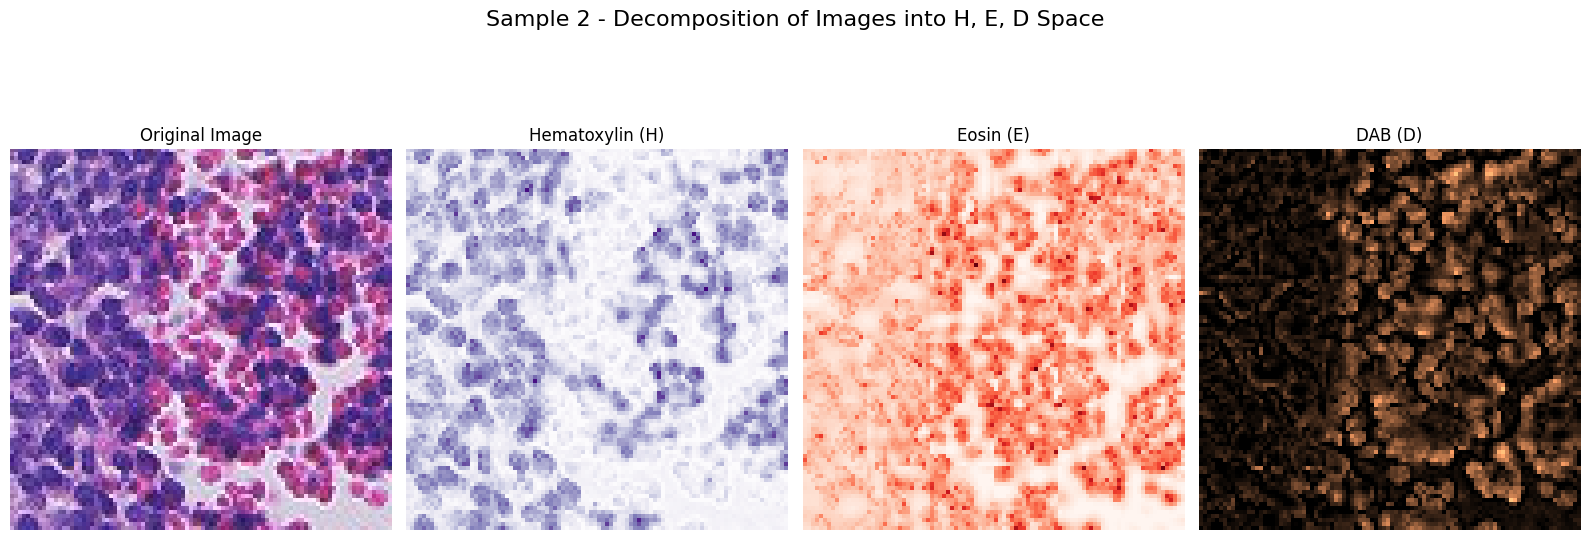

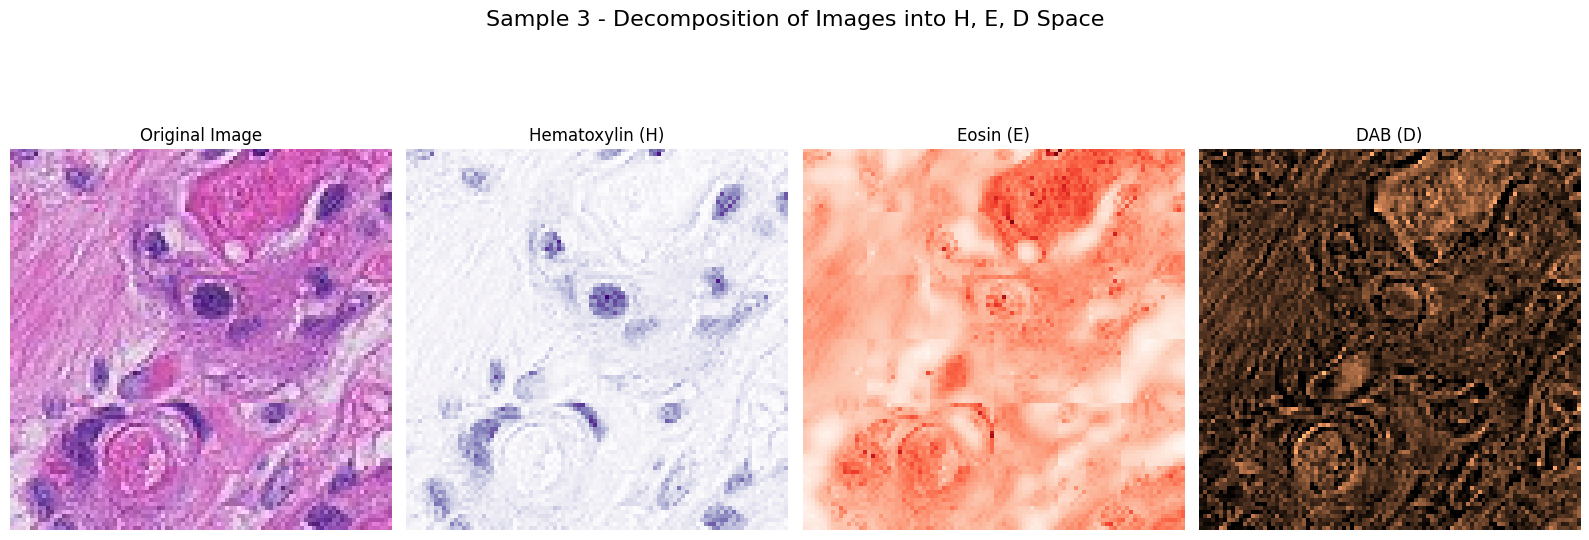

In [ ]:
def convert_to_hed(image):
    hed = rgb2hed(image) #Refer documentation - https://scikit-image.org/docs/stable/api/skimage.color.html. This line of code is translating an image from rgb space to the hed space.
    h = rescale_intensity(hed[..., 0], out_range=(0, 1))
    e = rescale_intensity(hed[..., 1], out_range=(0, 1))
    d = rescale_intensity(hed[..., 2], out_range=(0, 1))
    return h, e, d

def plot_image_and_hed_with_title(image, label, idx, title=None):
    #this particular function will use the above function for the space translation and then plot the component stains that are H,E,D
    image = image.numpy().astype("float32")

    h, e, d = convert_to_hed(image)

    plt.figure(figsize=(16, 6))

    if title:
        plt.suptitle(title, fontsize=16, y=1.02)

    #plotting the original image for easy interpretability.
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Hematoxylin (H)")
    plt.imshow(h, cmap="Purples")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Eosin (E)")
    plt.imshow(e, cmap="Reds")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("DAB (D)")
    plt.imshow(d, cmap="copper")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def visualize_hed_samples_with_title(dataset, num_samples=3, overall_title=None):

    samples_shown = 0

    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            if samples_shown >= num_samples:
                return

            title = f"Sample {samples_shown + 1} - {overall_title}" if overall_title else None
            plot_image_and_hed_with_title(image, label, samples_shown, title)
            samples_shown += 1

visualize_hed_samples_with_title(train_dataset, num_samples=3, overall_title="Decomposition of Images into H, E, D Space")


*We can see how the above slides are made up of its component dyes.*

#### d) Distribution of HED Intensities
##### *Motivation - Helps get an idea of which intensity is usually common among such images.*

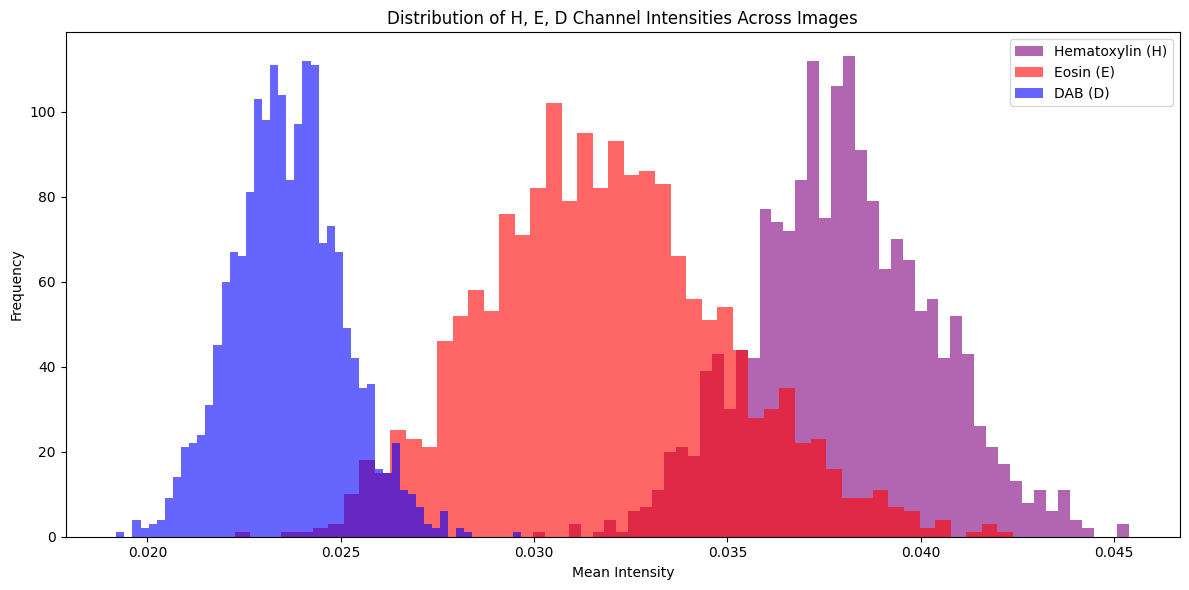

In [ ]:
def calculate_hed_means(dataset):

    #calculate mean intensities of each of the H,E,D components
    h_means, e_means, d_means = [], [], []

    for image, _ in tfds.as_numpy(dataset):
        image = image.astype("float32")
        hed = rgb2hed(image)
        h, e, d = hed[..., 0], hed[..., 1], hed[..., 2]
        h_means.append(np.mean(h))
        e_means.append(np.mean(e))
        d_means.append(np.mean(d))

    return h_means, e_means, d_means

def plot_hed_distribution_zoomed(h_means, e_means, d_means):

    #plot the mean intensities for all the images per H,E,D channel
    plt.figure(figsize=(12, 6))

    plt.hist(h_means, bins=50, alpha=0.6, label='Hematoxylin (H)', color='purple')
    plt.hist(e_means, bins=50, alpha=0.6, label='Eosin (E)', color='red')
    plt.hist(d_means, bins=50, alpha=0.6, label='DAB (D)', color='blue')

    all_means = h_means + e_means + d_means
    min_value = min(all_means)
    max_value = max(all_means)
    zoom_padding = (max_value - min_value) * 0.05
    plt.xlim(min_value - zoom_padding, max_value + zoom_padding)

    plt.title('Distribution of H, E, D Channel Intensities Across Images')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()

    plt.show()

h_means, e_means, d_means = calculate_hed_means(train_dataset)

plot_hed_distribution_zoomed(h_means, e_means, d_means)

*We can see above how intense are these dyes (on an average) in the images.*

#### **Saved Model Summary**
##### *Convolutional Neural Network + Attention Layer Model Architecture*

In [ ]:

class AttentionBlock(layers.Layer):
    def __init__(self, units, l2_factor=1e-4):
        super(AttentionBlock, self).__init__()
        self.units = units
        self.query_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.key_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.value_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))
        self.attention_output_dense = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_factor))

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        attention_output = tf.matmul(attention_weights, value)
        attention_output = self.attention_output_dense(attention_output)
        return attention_output

with custom_object_scope({'AttentionBlock': AttentionBlock}):
    attention_model = load_model('/content/drive/MyDrive/Davran_Colab/model_attention_improved.h5')

In [ ]:
attention_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 256)       2951

#### Predicted Output Vector

We got the predicted output vectors and assigned class labels according to their values. If value > 0.5 then label 1, elso 0

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = attention_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_pred

256/256 [==============================] - 38s 148ms/step


array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
y_pred.shape

(32768, 1)

### **Model Evaluation**

As you see, the results are significantly improved with the attention mechanism. In baseline CNN we got much lower results

#### a) Evaluation Metrics:
1. Accuracy
2. F1 Score
3. Precision
4. Recall


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.831
F1 Score: 0.808
Precision: 0.938
Recall: 0.709


#### b) Confusion Matrix

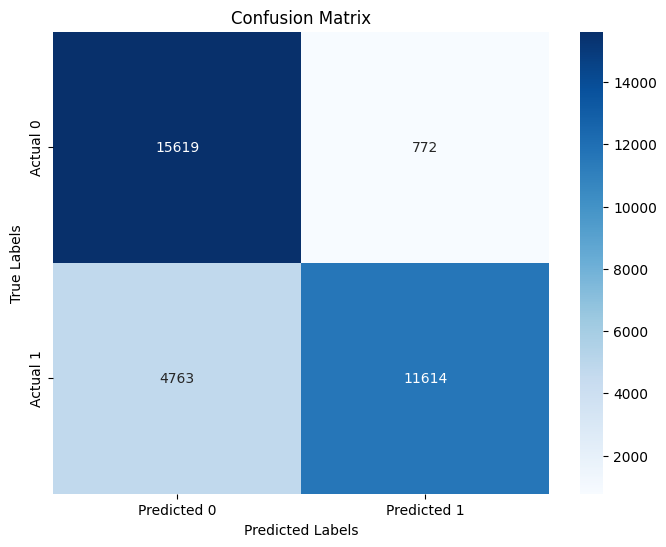

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### c) Gradient-weighted Class Activation Mapping

To gain insight into how the attention mechanism functions in our model, we generated and visualized Grad-CAM (Gradient-weighted Class Activation Mapping) heatmaps for training images. These heatmaps highlight the regions in the images that the model focuses on during its predictions.

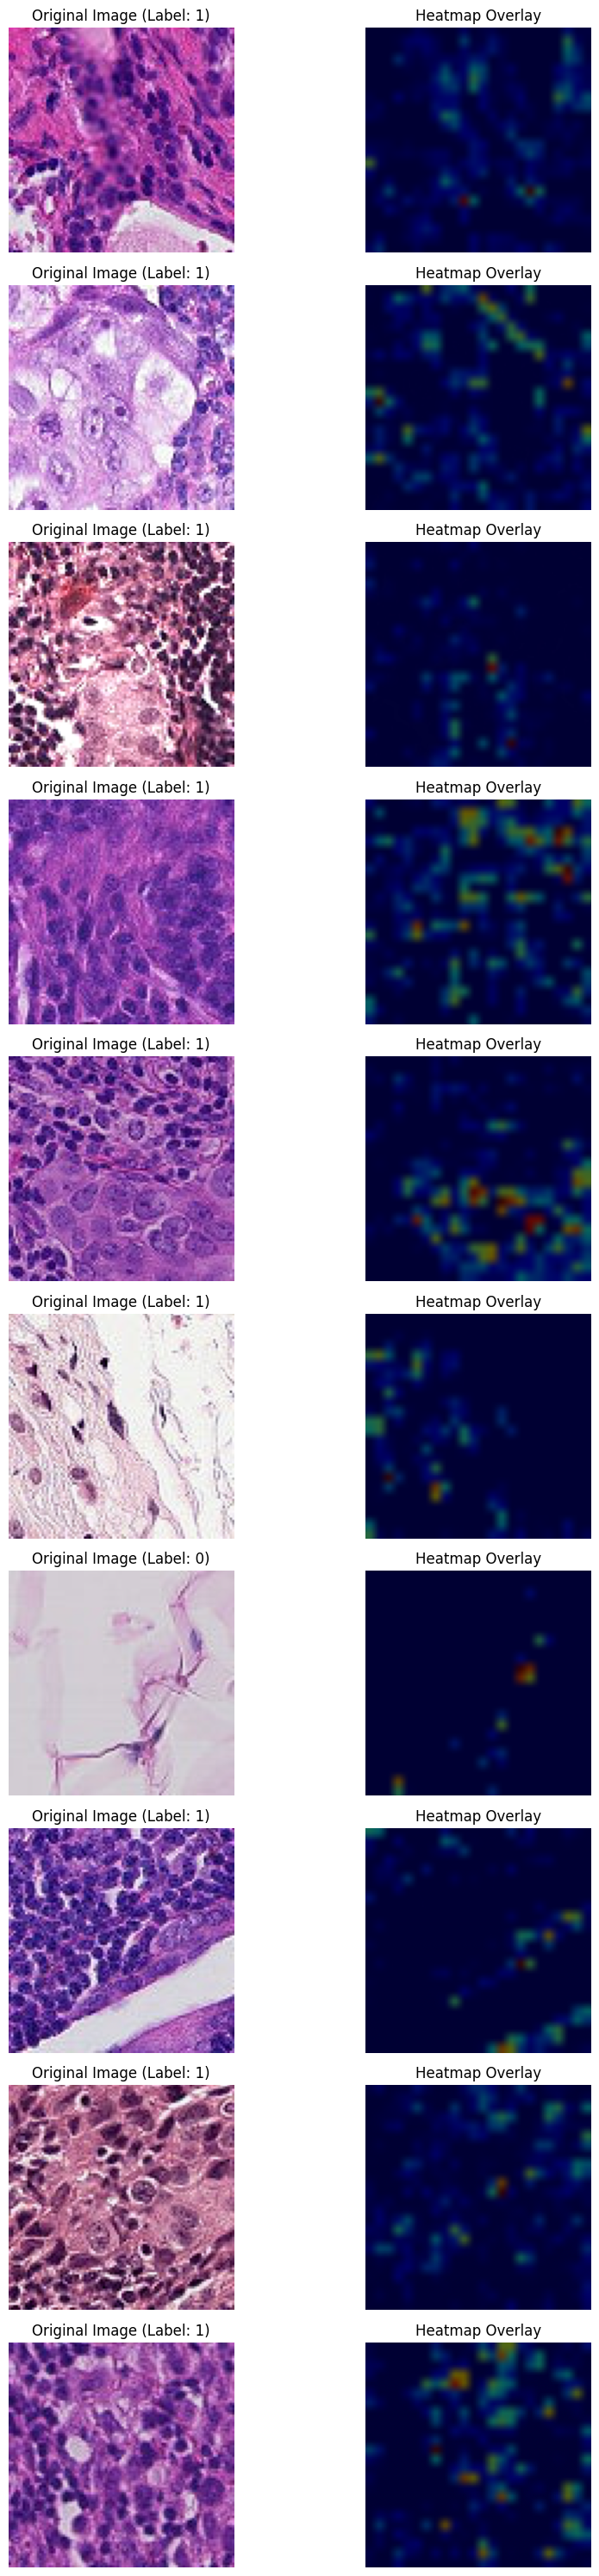

In [ ]:
def generate_gradcam(model, image, layer_name, class_index=None):

    image = tf.expand_dims(image, axis=0)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        feature_maps, predictions = grad_model(image)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_output = predictions[:, class_index]

    gradients = tape.gradient(class_output, feature_maps)
    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

    feature_maps = feature_maps[0]
    heatmap = tf.reduce_sum(pooled_gradients * feature_maps, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

def overlay_heatmap(image, heatmap, alpha=0.4):

    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.cm.jet(heatmap)[:, :, :3]
    heatmap = tf.image.resize(heatmap, (image.shape[0], image.shape[1])).numpy()

    overlay = alpha * heatmap + image / 255.0
    return np.clip(overlay, 0, 1)

def visualize_train_images(model, train_dataset, layer_name, num_images=10):

    for images, labels in train_dataset.take(3):
        images = images[:num_images]
        labels = labels[:num_images]

    plt.figure(figsize=(10, 3 * num_images))
    for i in range(num_images):
        heatmap = generate_gradcam(model, images[i], layer_name)

        overlay = overlay_heatmap(images[i].numpy(), heatmap)

        plt.subplot(num_images, 2, 2 * i + 1)
        plt.title(f"Original Image (Label: {labels[i].numpy()})")
        plt.imshow(images[i])
        plt.axis("off")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.title("Heatmap Overlay")
        plt.imshow(overlay)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

layer_name = "conv2d_5"
visualize_train_images(attention_model, train_dataset, layer_name, num_images=10)